# Scientific Programming and Dynamical Modelling in Julia
#### Winter Semester 23/24, TUM
---
## Exercise 2: Differential Equations in Julia

In [2]:
import Pkg; Pkg.activate("env_ex2.jl")
using Plots

  Activating project at `c:\Users\colin\OneDrive-TUM\Code\Julia\MMDS_Julia\env_ex2.jl`

### The Lorenz System

In [3]:
# Lorenz '63 (OOP)
function f(u, p, t)
    x, y, z = u
    σ, β, ρ = p
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return [dx, dy, dz]
end

f (generic function with 1 method)

### Initial Conditions and Parameters

In [4]:
u0 = rand(3)                # Initial conditions
tspan = (0.0, 10.0)         # Timespan of the integration
dt = 0.01                   # time step
p = [10.0, 8 / 3, 28.0];    # Parameters (optional)

### Define the Euler Solvers

In [5]:
function Euler_simple(f, u0, p, tspan, dt)
    t = collect(tspan[1]:dt:tspan[2])
    u = -1 * ones(length(u0), length(t))
    u[:, 1] = u0
    for (i, t_) in enumerate(t[1:end-1])
        u[:, i+1] = u[:, i] + f(u[:, i], p, t_) * dt
    end
    return t, u
end


function Euler_improv(f, u0, p, tspan, dt)
    t = collect(tspan[1]:dt:tspan[2])
    u = zeros(length(u0), length(t))
    u[:, 1] = u0
    for (i, t_) in enumerate(t[1:end-1])
        u_tilde = u[:, i] + f(u[:, i], p, t_)*dt
        u[:, i+1] = u[:, i] + 0.5 * (f(u[:, i], p, t_) + f(u_tilde, p, t_)) * dt
    end
    return t, u
end

Euler_improv (generic function with 1 method)

### Run the Solvers (Lorenz '63)

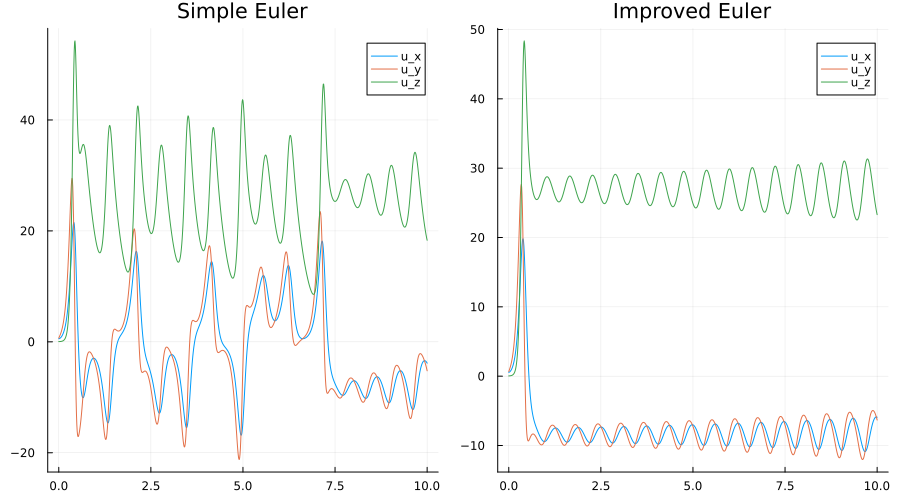

In [6]:
t_simple, u_simple = Euler_simple(f, u0, p, tspan, dt)
t_improv, u_improv = Euler_improv(f, u0, p, tspan, dt)

l = @layout [a b]
fig = plot(t_simple, u_simple', title="Simple Euler", label=["u_x" "u_y" "u_z"], subplot=1, layout=l, size=(900, 500))
plot!(fig[2], t_improv, u_improv', title="Improved Euler", label=["u_x" "u_y" "u_z"], subplot=2, layout=l)


┌ Info: Saved animation to C:\Users\colin\AppData\Local\Temp\jl_mhaZMpEz4l.gif
└ @ Plots C:\Users\colin\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\colin\\AppData\\Local\\Temp\\jl_mhaZMpEz4l.gif")
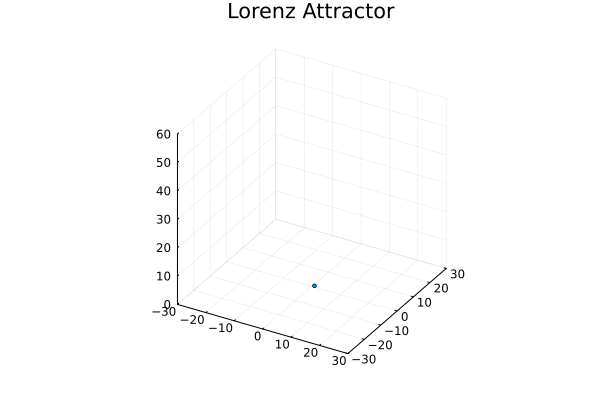

In [7]:
plt = plot3d(
    1,
    xlim = (-30, 30),
    ylim = (-30, 30),
    zlim = (0, 60),
    title = "Lorenz Attractor",
    legend = false,
    marker = 2
)

# build an animated gif by pushing new points to the plot, saving every 10th frame
@gif for (x, y, z) in eachcol(u_simple)
    push!(plt, x, y, z)
end every 10

## Lotka-Volterra System
A simple predator-prey model, with $H$ representing the hares and $F$ the foxes.

$ \frac{dH}{dt} = \alpha H - \beta H F \\
   \frac{dF}{dt} = -\gamma F + \delta H F $
   
First, define the differential equation:

In [8]:
function lotka_volterra(u, p, t)
    h, f = u
    alpha, beta, gamma, delta = p

    dh = alpha*h - beta*h*f
    df = -gamma*f + delta*h*f

    return [dh, df]
end

lotka_volterra (generic function with 1 method)

Then, define the initial conditions and parameters of the LV-System, and additional integration settings

In [9]:
u0 = [20., 5.]
p = [1., 0.5, 1., 0.2]

dt = [0.01, 0.05, 0.1]
tspan = [0, 50];

Run the experiment for both solvers and different step sizes:

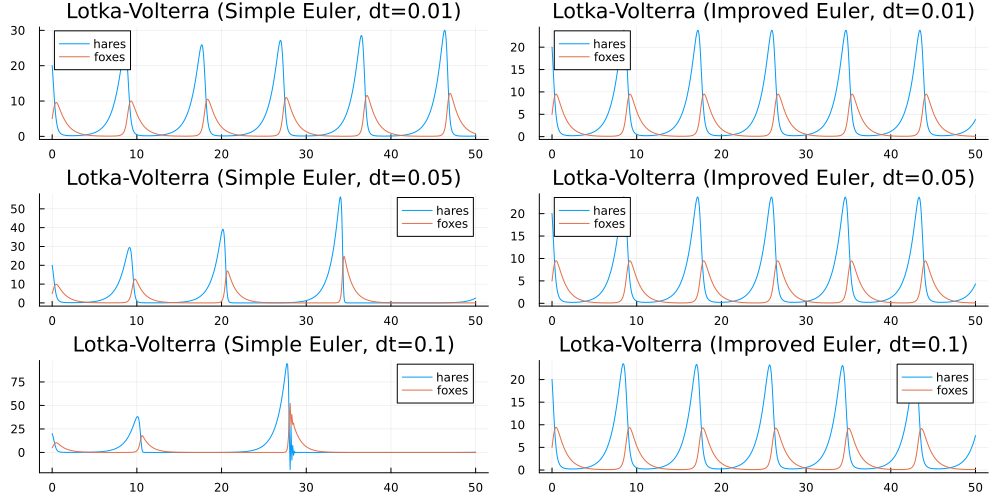

In [10]:
plt = plot(layout=(length(dt), 2), size=(1000, 500))
for (i, dt_) in enumerate(dt)
    t_simple, u_simple = Euler_simple(lotka_volterra, u0, p, tspan, dt_)
    t_improv, u_improv = Euler_improv(lotka_volterra, u0, p, tspan, dt_)
    plot!(t_simple, u_simple', subplot=(i-1)*2+1, title="Lotka-Volterra (Simple Euler, dt=$dt_)", label=["hares" "foxes"])
    plot!(t_improv, u_improv', subplot=(i-1)*2+2, title="Lotka-Volterra (Improved Euler, dt=$dt_)", label=["hares" "foxes"])
end
plt

**Observations:** 

The solution of the simple Euler already changes slightly when changing the step size from $dt=0.01$ to $dt=0.05$, while visually, no difference in solution can be seen for the improved Euler.

The effect is much stronger for $dt=0.1$, where the quality of solution of the simple Euler deteriorates dramatically, while the simple Euler solution still appears almost unchanged.

### Using *DifferentialEquations.jl*
After importing the package, we define the ODEProblem associated with the Lotka-Volterra System.

In [11]:
import DifferentialEquations: Tsit5, Vern8, Rosenbrock23, solve, ODEProblem
import BenchmarkTools: @btime
prob = ODEProblem(lotka_volterra, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: false
timespan: (0, 50)
u0: 2-element Vector{Float64}:
 20.0
  5.0

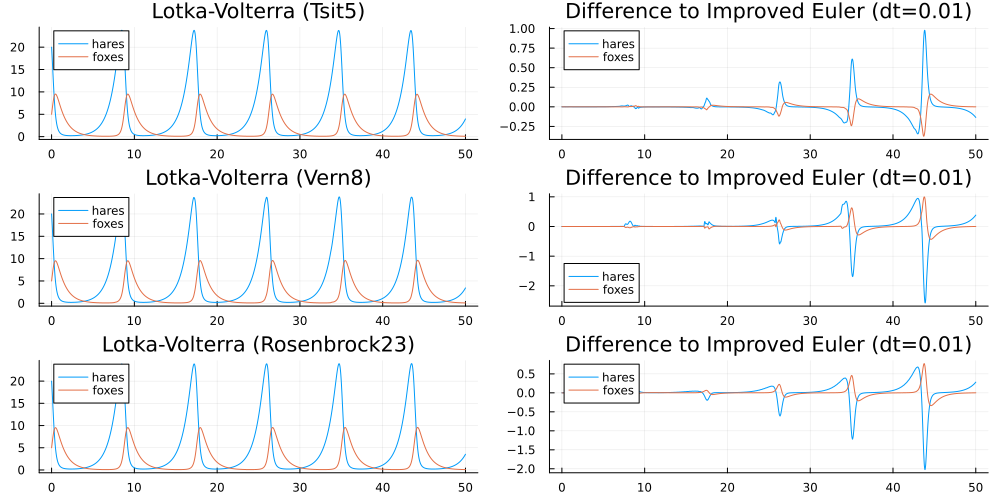

In [12]:
# reference solutions
dt = 0.01
t_simple, u_simple = Euler_simple(lotka_volterra, u0, p, tspan, dt)
t_improv, u_improv = Euler_improv(lotka_volterra, u0, p, tspan, dt)

# experiments with predefined solvers
solvers = [Tsit5, Vern8, Rosenbrock23]
plt = plot(layout=(length(solvers), 2), size=(1000, 500))
for (i, s_) in enumerate(solvers)
    # @btime solution = solve(prob, s_(), saveat = dt)  # doesnt work
    solution = solve(prob, s_(), saveat = dt)
    diff_improv = u_improv - solution
    diff_simple = u_improv - solution
    plot!(t_simple, solution', subplot=(i-1)*2+1, title="Lotka-Volterra ($s_)", label=["hares" "foxes"])
    plot!(t_improv, diff_improv', subplot=(i-1)*2+2, title="Difference to Improved Euler (dt=$dt)", label=["hares" "foxes"])
    # plot!(t_improv, diff_simple', subplot=(i-1)*2+2, title="Difference to Simple Euler (dt=$dt)", label=["hares" "foxes"], linestyle=:dashdot)
end
plt

### Phase Plots
The suboptimal performance of the simple Euler solver can also be visualized by means of a phase plot. The closed contour of the improved Euler suggests an osicllatory behavior of the LV-System. However, the contour of the simple Euler solution is not closed, indicating the poor performance of the solver.

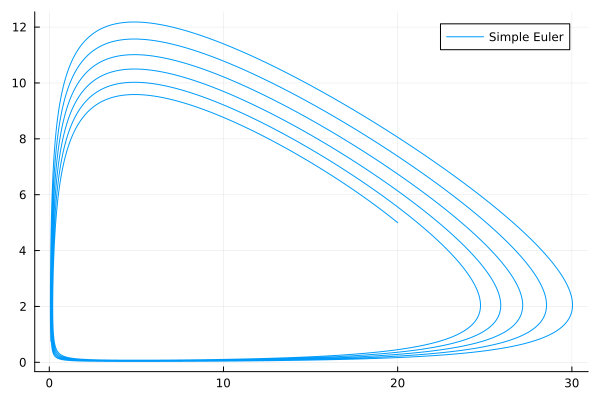

In [13]:
plot(u_simple[1, :], u_simple[2, :], label="Simple Euler")
# plot!(u_improv[1, :], u_improv[2, :], label="Improved Euler")